In [25]:
import spikeinterface.full as si
import probeinterface as pi
from pathlib import Path
import woodsort
import numpy as np 
import matplotlib.pyplot as plt

In [3]:

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
session_path = '/home/avadher/Data/H7113-250604/'

# set parameters for probe
shank_groups = [0, 1] # specify which groups in the Neuroscope xml file are shanks of the probe
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# Set paths 
session_path = Path(session_path)
session_name = session_path.name


Using XML file: /home/avadher/Data/H7113-250604/2025-06-04_14-46-12/Record Node 101/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml


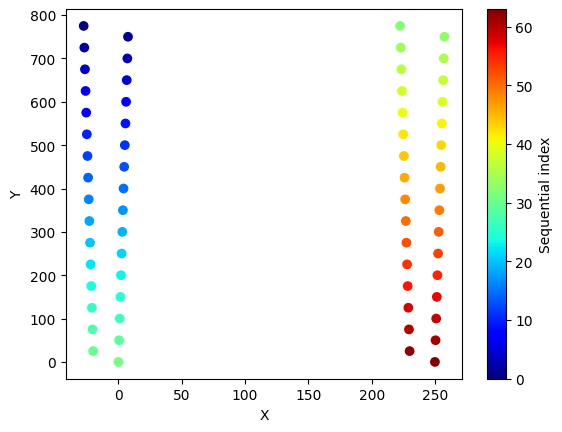

In [27]:
### Prepare the probe based on probeinterface layout and Neuroscope mapping ###

# Neuroscope mapping denotes the sequence of recording channels in the recording file, from top to bottom of each shank and from left to right shank-wise
# Sorting according to Neuroscope order results in anatomical mapping

# Load recording and probe, preprocess and fill channel indices from Neuroscope
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name) # pi.list_all_probes() to list all probes 

# Load Neuroscope channel mapping
channel_mapping = woodsort.neuroscope.load_neuroscope_channels(session_path)

# Get channel indices corresponding to the probe
neuroscope_channel_indices = (
    channel_mapping.loc[
        channel_mapping["channel_group"].isin(shank_groups),
        "channel_0based",
    ].tolist()
)

# sort channels based on their coordinates, top to bottom and shank-wise
sorted_coordinates_by_shank = []
for unique_id in np.unique(probe.shank_ids):
    id_indices = np.where(probe.shank_ids == unique_id)[0]
    coors = probe.contact_positions[id_indices]
    coors = coors[coors[:, 1].argsort()[::-1]]
    sorted_coordinates_by_shank.append(coors)
final_sorted_coordinates = np.vstack(sorted_coordinates_by_shank)

plt.scatter(final_sorted_coordinates[:, 0], final_sorted_coordinates[:, 1], c=np.arange(len(final_sorted_coordinates)), cmap='jet')
plt.colorbar(label="Sequential index")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Device coordinates are rearranged top to bottom of each shank")
plt.show()

# Update probe with sorted coordinates
probe.set_contacts(
    final_sorted_coordinates,
    shapes=probe.contact_shapes,
    shape_params=probe.contact_shape_params,
    plane_axes=probe.contact_plane_axes,
    contact_ids=np.arange(len(neuroscope_channel_indices)),
    shank_ids=np.sort(probe.shank_ids),  # Sorted shank_ids
)

# Set device channel indices
probe.set_device_channel_indices(neuroscope_channel_indices)

   

In [37]:
print('\nNew device channel indices from Neuroscope')
print(probe.device_channel_indices)
print('\nContact IDs are labelled top to bottom')
print(probe.contact_ids)

# add probe to the recording
recording = si.read_openephys(session_path,stream_id='0')
recording = recording.set_probe(probe, group_mode="by_shank")
print('\nDevice channel indices are reset after adding the probe to the recording')
print(recording.get_probe().device_channel_indices)
print('\nContact IDs are mixed up after adding the probe to the recording')
print(recording.get_probe().contact_ids)




New device channel indices from Neuroscope
[22  4 13  6 15 29 24  2 11 16 20 30  7  1  9  0 21 62  8 31 25 19 12  3
 10 28 23 18 14  5 27 26 36 37 59 48 44 41 34 52 61 50 45 39 33 54 47 43
 17 55 63 57 32 42 46 53 60 38 35 49 56 51 58 40]

Contact IDs are labelled top to bottom
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63']

Device channel indices are reset after adding the probe to the recording
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]

Contact IDs are mixed up after adding the probe to the recording
['15' '13' '7' '23' '1' '29' '3' '12' '18' '14' '24' '8' '22' '2' '2